# Policy Gradient 套用到 Breakout 上
---
注意！！  
Breakout 只能在 linux or mac 上面跑  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import gym

from skimage import transform
from RLAgent_PolicyGradient_CNN import PolicyGradient

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Observaton space: (210, 160, 3)
Action: 4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


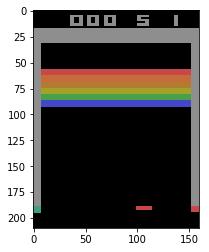

In [2]:
# 創建環境
env = gym.make("Breakout-v4")
imgShape = env.observation_space.shape
numAction = env.action_space.n

# Print 結果
# 記得！！ shape(0) => rows(height), shape(1) => cols(width)
print("Observaton space: " + format(imgShape))
print("Action: " + format(numAction))
print(env.unwrapped.get_action_meanings())

# 顯示測試
img = env.reset()
plt.imshow(img)
plt.show()

# 測試動作
---

In [3]:
# 因為 matplotlib 在顯示大的圖片會比較慢，所以 scale 一下圖會比較快
plotScale = 10
fontSize = 15

In [28]:
# 分成五格看
def ShowAction(action):
    fig, axes = plt.subplots(1, 5)

    # 顯示設定
    # 記得！！ shape(0) => rows(height), shape(1) => cols(width)
    fig.set_figwidth(imgShape[1] / plotScale)
    fig.set_figheight(imgShape[0] / plotScale)
    fig.subplots_adjust(wspace=0.5)

    # 先歸零，在做第 0 個動作
    img = env.reset()
    axes[0].imshow(img)
    axes[0].set_xlabel("Start", fontsize = fontSize)
    for i in range(1, 5):
        img, reward, IsDone, Info = env.step(action)
        axes[i].imshow(img)

        info = "Reward: " + format(reward) + "\nIsDone: " + format(IsDone) + "\nInfo: " + format(Info)
        axes[i].set_xlabel(info, fontsize = fontSize)

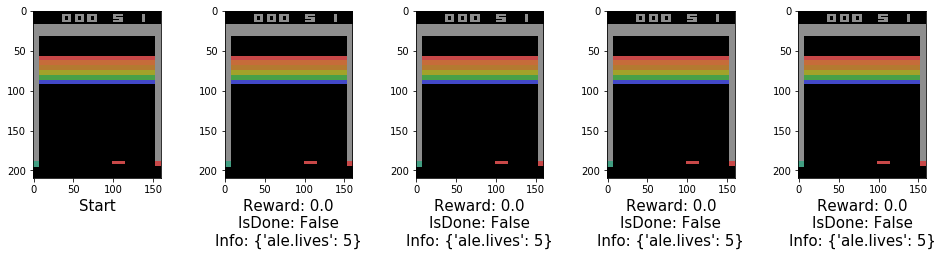

In [29]:
# no-op
ShowAction(0)

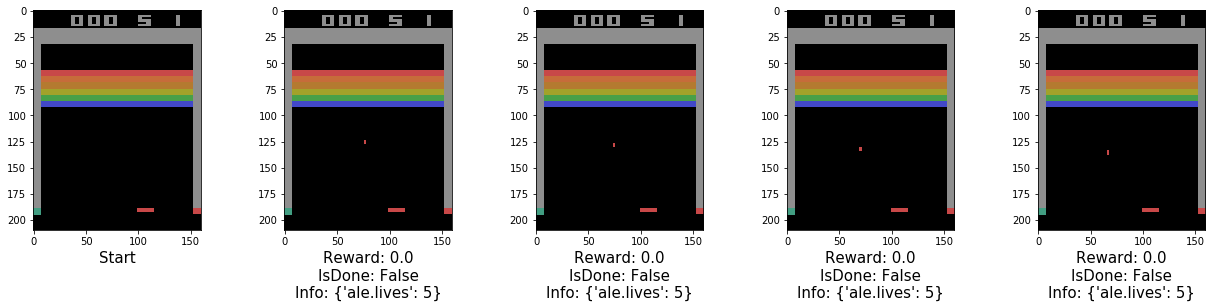

In [6]:
# Fire
ShowAction(1)

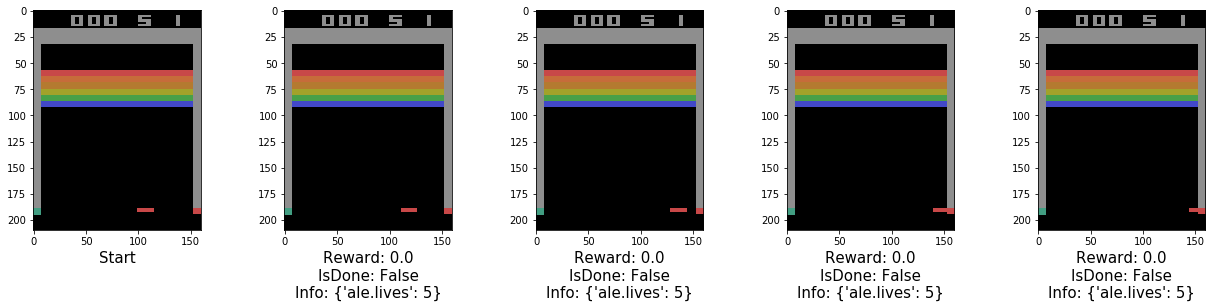

In [7]:
# Right
ShowAction(2)

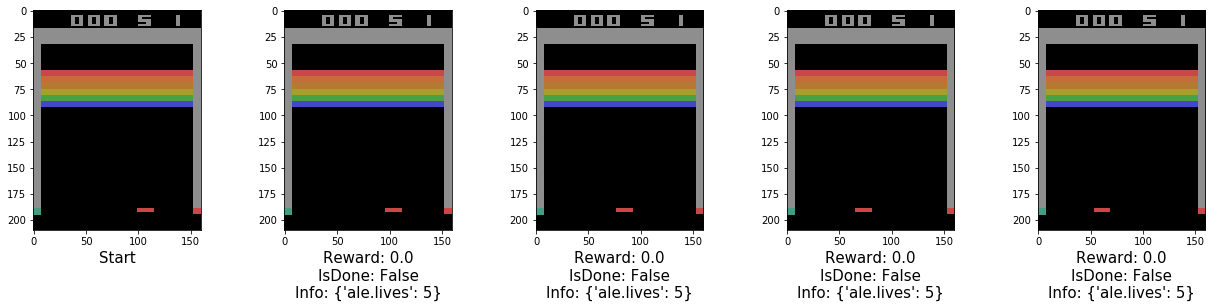

In [8]:
# Left
ShowAction(3)

## 對圖片做處理
---
因為圖片太大了  
而且 Features 也不是很多  
所以會先轉成灰階在縮小

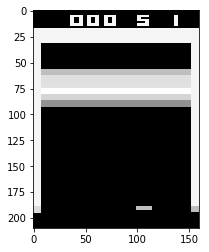

In [9]:
# 去掉顏色的 Feature
def img2gray(img):
    value = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
    return value

# 測試顯示出來世不是灰階
plt.imshow(img2gray(env.reset()), cmap="gray")
plt.show()

(105, 80)


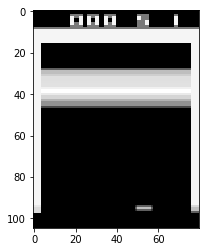

In [31]:
# 重新縮小 k 倍
# 記得！！ shape(0) => rows(height), shape(1) => cols(width)
smallSize = 2
smallSizeArray = (int(imgShape[0] / smallSize), int(imgShape[1] / smallSize))
def reshapeImg(img):
    smallImg = transform.resize(img, smallSizeArray, mode="constant")
    return smallImg

print(smallSizeArray)
plt.imshow(reshapeImg(img2gray(env.reset())), cmap="gray")
plt.show()

In [11]:
# 圖片處理
def ImagePreprocess(img):
    grayImg = img2gray(img)
    outputImg = reshapeImg(grayImg)
    return outputImg

## 開始見 AI 來訓練
---

In [12]:
# 設定輸入的參數
# 單張輸入大小
# 記得！！ shape(0) => rows(height), shape(1) => cols(width)
SingleInputSize = smallSizeArray[0] * smallSizeArray[1]
# 輸入幾張圖片
InputImageSize = 5

In [13]:
Agent = PolicyGradient(
    n_actions = numAction,
    imgRows = smallSizeArray[0],
    imgCols = smallSizeArray[1],
    imgNumber = InputImageSize,
    imgChannel = 1,
    LearningRate = 0.02
    # IsOutputGraph=True
)

42000


In [23]:
# 叫紀錄遊玩的過去 n 個 Frame 的資料
PastImage = np.zeros((smallSizeArray[0], smallSizeArray[1], InputImageSize - 1), dtype = np.uint8)

In [26]:
def TrainModel(epoch):
    global PastImage
    
    # 重新開始，先把 PastImage 初始化
    observation = env.reset()
    
    # 處理圖片
    processOb = ImagePreprocess(observation)
    
    # 先產生開始圖片 n - 1 張，因為輸入要是 n 張圖片
    for i in range(0, InputImageSize - 1):
        PastImage[:, :, i] = processOb
    #env.render()
    
    
    PastImage = np.dstack((PastImage,processOb))
    feedData = {Agent.observations: [PastImage]}
    outputImage = Agent.session.run(Agent.obImageArray, feed_dict= feedData)
    plt.imshow(outputImage[0])
    plt.show()
    
    for i in range(0, epoch):
        break
        # 產生前 n 筆的資料當輸入，選擇動作
        PastImage = np.dstack((PastImage,processOb))
        
        # 因為輸入是多張 2 維的圖片，所以要把他攤平輸入
        action = Agent.chooseAction(observation = PastImage)
        
        # 執行
        nextOberservation, reward, IsDone, Info = env.step(action)
        
        nextProcessOb = ImagePreprocess(nextOberservation)
        
        # 存到 Memory 裡
        Agent.storeTransition(
            observation = PastImage,
            reward = reward,
            action= action
        )
        
        if(IsDone):
            env.render(close = True)
            break
            
        # 覆蓋掉以前的部分
        processOb = nextProcessOb
        
        # 並刪掉最前面的 Image
        PastImage = np.delete(PastImage, 0, 0)
        env.render()

In [27]:
TrainModel(300)

ValueError: Cannot feed value of shape (1, 105, 80, 6) for Tensor 'Input/observations:0', which has shape '(?, 42000)'

In [ ]:
1
